# Two Parameter function fitting
This takes the function model example and uses it on a 2D function. We will utilize this for a free energy that is a function of $T$ and $c$.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle
from IPython import display
import os

In [3]:
training_epochs = 10000
display_step = training_epochs*0.2
epoch_plots = True
test_fraction = 0.75

#### Neural Network size parameters

In [4]:
n_input = 2
hidden_nodes = 100
n_hidden_0 = hidden_nodes
n_hidden_1 = hidden_nodes
n_hidden_2 = hidden_nodes
n_hidden_3 = hidden_nodes
n_hidden_4 = hidden_nodes
n_hidden_5 = hidden_nodes
n_hidden_6 = hidden_nodes

num_of_hidden_layers = 7
n_output = 1

#### Load input data from file

In [5]:
data = pd.read_csv('data.dat', sep=" ", header=None)
num_examples = len(data[0])

### Training/Testing Set Creation

Create shuffled data. Split into training and testing sets based on the `test_fraction` value

In [6]:
np.random.seed(42)
shuffled_indices = np.random.permutation(num_examples)
train_size = int(num_examples*test_fraction)
train_indices = shuffled_indices[:train_size]
test_indices  = shuffled_indices[train_size:]


train_data = np.transpose(data.iloc[train_indices].values)
test_data = np.transpose(data.iloc[test_indices].values)
all_data = np.transpose(data.values)

# Partition data
T_training = train_data[0]
T_testing  = test_data[0]
T_all      = all_data[0]
c_training = train_data[1]
c_testing  = test_data[1]
c_all      = all_data[1]
G_training = train_data[2]
G_testing  = test_data[2]
G_all      = all_data[2]


### Data plotting

Plot test and training data for visual inspection

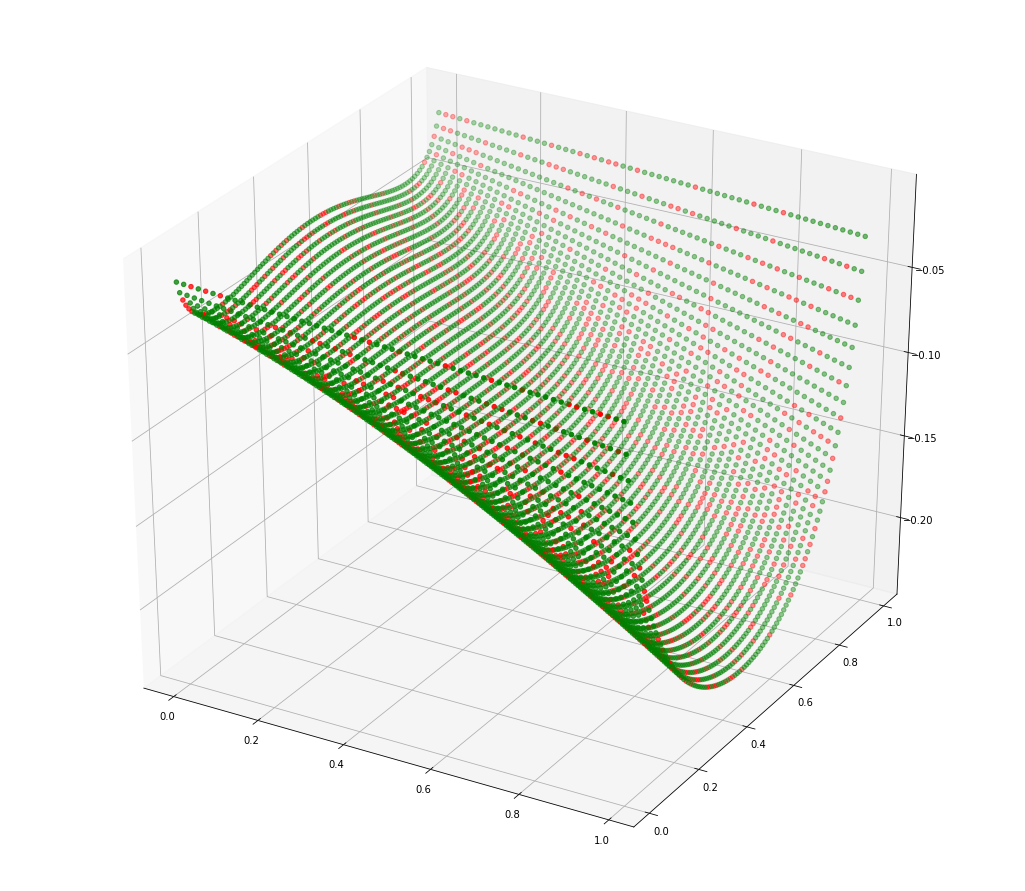

In [7]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T_training, c_training, G_training, color='g')
ax.scatter(T_testing, c_testing, G_testing, color='r')

In [8]:
tf.reset_default_graph()

### Graph Creation

Create a network with 7 hidden layers. This number is chosen only for example. Depending on the chosen f(x), additional or fewer layers may be needed. similarily the number of nodes in each layer can be tuned for specific choices of functions.

The NN function function takes an input tensor and number of hidden layers. It will then use the weight tensors defined in `weights`, and use biases defined in `biases`.

In [9]:
X = tf.placeholder("float", [None, n_input], name='X')
Y = tf.placeholder("float", [None, n_output], name='Y')


weights = {
    'h0': tf.Variable(tf.random_normal([n_input, n_hidden_0])),
    'h1': tf.Variable(tf.random_normal([n_hidden_0, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_hidden_6, n_output])),
}

biases = {
    'h0': tf.Variable(tf.random_normal([n_hidden_0])),
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_output])),
}


def NN(input_layer, n):
    '''
        x: Input Tensor
        n: number of hidden layers to build
        
        Returns: output layer
        
        Builds a network starting with `input_layer`, containing n hidden
        layers, and returns `output` layer.
    '''
    def __build_hidden(inpt_layer, n):
        # Layer Number counter
        ln = 0
        layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        inpt_layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
        # Increment Layer Number
        ln += 1
        while ln < n:
            layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
            ln += 1
        return layer        
    
    
    layer = __build_hidden(input_layer, n)
    
    output = tf.add(
                tf.matmul(
                    layer, weights['out'],
                    name="out"
                ),
                biases['out']
            )
    return output


### Network and Training Optimizer Initialization

Build Neural Network using `NN()` function. Create cost function, and link optimizer.

In [10]:
output = NN(X, num_of_hidden_layers)
cost = tf.reduce_mean(tf.pow(output - Y, 2))
optimizer = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(output - Y))

In [11]:
init = tf.global_variables_initializer()

In [12]:
sess = tf.InteractiveSession()

### Training

Train network on training set. Track network error on validation set as well as test set. At marked epoches, print the current cost, and plot the networks best ability to model the data. This plotting makes the training *much* slower. Modifying the `1==1` condition is an easy way to enable/disable it.

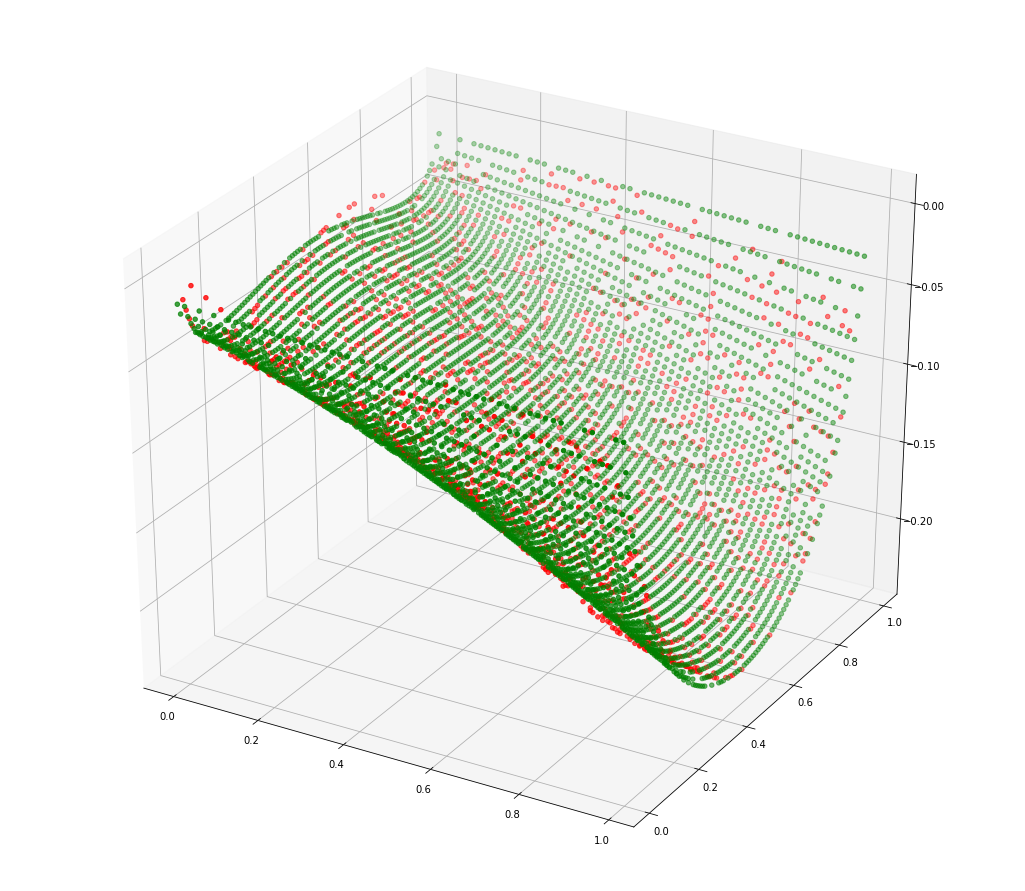

In [ ]:
costs = []
epoches = []
total_error = []

Tc_training_T = np.transpose([T_training, c_training])
G_training_T = np.transpose([G_training])

Tc_testing_T = np.transpose([T_testing, c_testing])

# Add ops to save and restore all the variables
saver = tf.train.Saver()
if not os.path.exists('two_parameter_fitting'):
    os.makedirs('two_parameter_fitting')

sess.run(init)

for epoch in range(training_epochs):
    _, c = sess.run(
        [ optimizer, cost ],
        feed_dict={
            X:Tc_training_T,
            Y:G_training_T
        }
    )

    costs.append(c)
    epoches.append(epoch)
    
    mse = sess.run(tf.nn.l2_loss(output - G_testing),  feed_dict={X:Tc_testing_T})
    total_error.append(mse)
    
    if epoch%display_step == 0:
        print('Epoch: %05d\tCost: %.4e'%(epoch, c))

        if epoch_plots:
            fig = plt.figure(figsize=(18, 16))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(T_training, c_training, G_training, color='g')
            ax.scatter(T_testing, c_testing, sess.run(output, feed_dict={X: Tc_testing_T}), color='r')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
            # Uncomment the following line to save images
            fig.savefig("two_parameter_fitting/%4d_training_plot.jpg"%(epoch))

    
print('Epoch: %05d\tMSE: %.4e'%(epoch+1, c))
print('Training complete!')

# Save checkpoint, graph.pb and tensorboard
saver.save(sess, "two_parameter_fitting/model.ckpt") 
tf.train.write_graph(sess.graph.as_graph_def(), "two_parameter_fitting/", "graph.pb")
tf.summary.FileWriter("board", sess.graph)


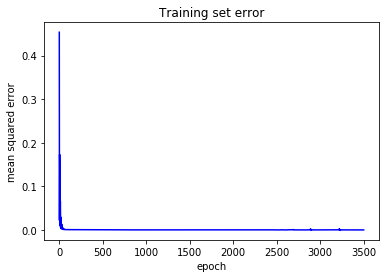

In [80]:
plt.plot( epoches, costs, 'b' )
plt.title('Training set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

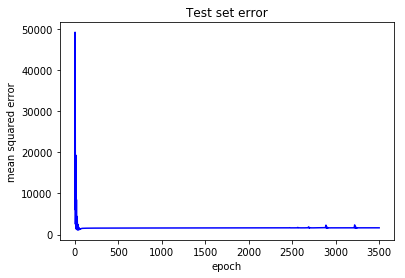

In [81]:
plt.plot( epoches, total_error, 'b' )
plt.title('Test set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

### Model Prediction

Plot the model across all data, overalyed with original data.

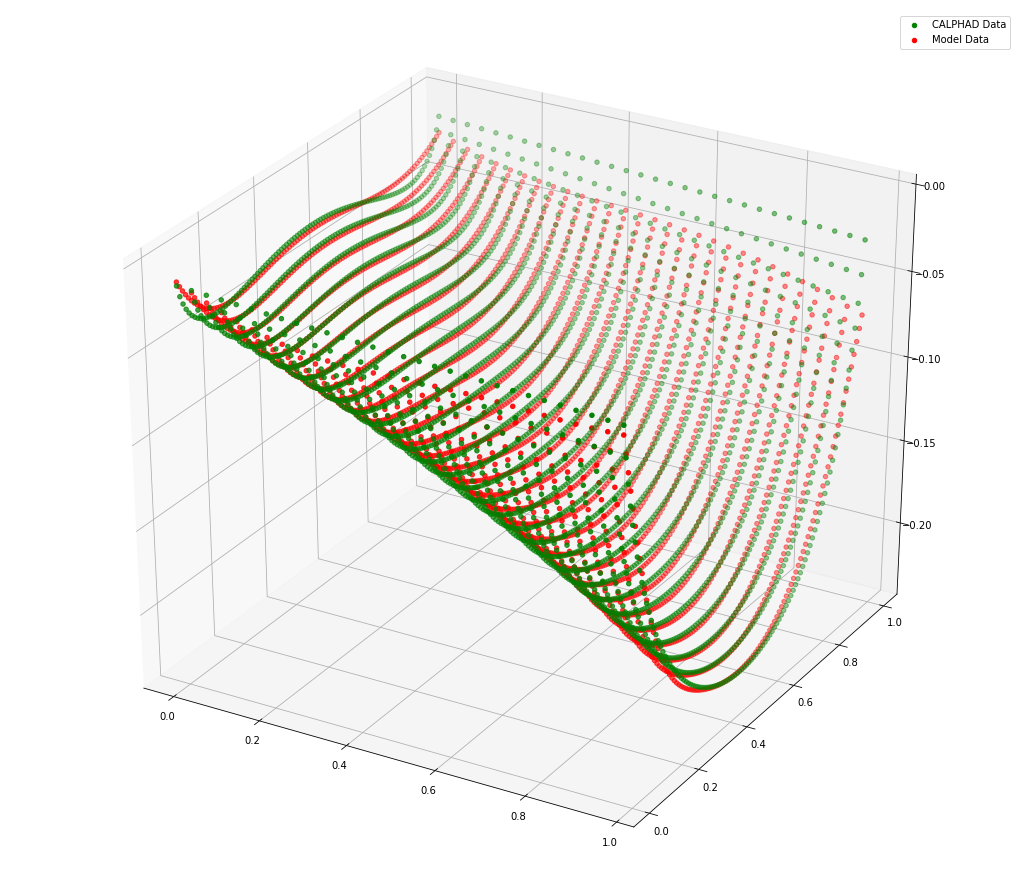

In [85]:
Tc_all_T = np.transpose([T_all, c_all])
G_all_T = np.transpose([G_all])

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
#ax.title('Neural Network Function Model')
ax.scatter(T_all, c_all, G_all, color='g', label='CALPHAD Data')
ax.scatter(T_all, c_all, sess.run(output, feed_dict={X: Tc_all_T}), color='r', label='Model Data')
ax.legend()

plt.show()